# Not working! 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from DataProcessing import Data

In [2]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [3]:
chosen_index = 'AAPL'

In [4]:
d.preprocess(chosen_index)

Processing AAPL.csv
Saved AAPL data at data/processed/AAPL.csv


In [5]:
df = d.get_data(chosen_index)

In [6]:
df.columns

Index(['Date', 'Close', 'Volume', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

In [7]:
df = df.drop(['Date','Volume'],axis=1)
df

,Close,RSI,MFI,EMA,SO,MACD,Next Day Price
0,46.026634,67.268429,64.270909,45.237070,61.538472,44.632211,46.695705
1,46.695705,69.300647,63.761773,45.431555,75.743466,44.842325,47.015808
2,47.015808,68.621752,63.849196,45.642788,83.225880,45.002530,47.097633
3,47.097633,66.415042,62.339650,45.836768,84.744426,45.129992,47.412914
4,47.412914,65.721236,61.764142,46.046921,94.736718,45.293776,48.159019
...,...,...,...,...,...,...,...
1240,170.119995,18.228278,16.817383,180.247559,3.142677,182.756270,169.119995
1241,169.119995,18.143279,16.653482,178.763884,2.689501,182.207957,169.000000
1242,169.000000,18.274975,16.636314,177.462033,3.081540,181.714985,170.729996
1243,170.729996,25.466088,24.061516,176.564428,13.534694,181.438270,172.750000


In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y= y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return self.x[i],self.y[i]

In [9]:
input_dim = 6
sequence_length = 14
hidden_size = 64
num_layers = 1
learning_rate = 0.001
batch_size = 8
num_epochs = 100

In [10]:
X = df[df.columns[0:6]].values
Y = df[df.columns[6]].values

In [11]:
TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = torch.FloatTensor(X[0:train_size])
Y_train = torch.FloatTensor(Y[0:train_size])
X_test = torch.FloatTensor(X[train_size:len(X)])
Y_test = torch.FloatTensor(Y[train_size:len(Y)])


In [12]:
time_series_dataset = TimeSeriesDataset(X_train,Y_train)
train_loader = DataLoader(time_series_dataset,batch_size=1,shuffle=False)

In [13]:
time_series_dataset[0:3]

(tensor([[46.0266, 67.2684, 64.2709, 45.2371, 61.5385, 44.6322],
         [46.6957, 69.3006, 63.7618, 45.4316, 75.7435, 44.8423],
         [47.0158, 68.6217, 63.8492, 45.6428, 83.2259, 45.0025]]),
 tensor([46.6957, 47.0158, 47.0976]))

In [14]:
for _,batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([1, 6]) torch.Size([1])


In [20]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers):
        super(RecurrentNeuralNetwork,self).__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim,hidden_size,num_layers,True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self, x,h_t):
        # h_0 = torch.zeros(self.num_layers,self.hidden_size)
        return self.rnn(x,h_t)

In [16]:
import torch.optim as optim
import torch.nn.functional as func
from torch.utils.data import DataLoader 

In [21]:
torch.manual_seed(39)
model = RecurrentNeuralNetwork(input_dim,hidden_size,num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)


In [18]:
model

RecurrentNeuralNetwork(
  (rnn): RNN(6, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
losses = []
y_pred = []
for i in range(50): 
    model.train(True)
    print(f'epoch: {i}')
    running_loss = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch,y_batch = batch[0],batch[1]
        output = model.forward(x_batch)
        y_pred.append(output)
        loss = criterion(output, y_batch)
        running_loss+=loss.detach().numpy()
        # losses.append(loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    losses.append(running_loss)

epoch: 0


/home/nguyen/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49


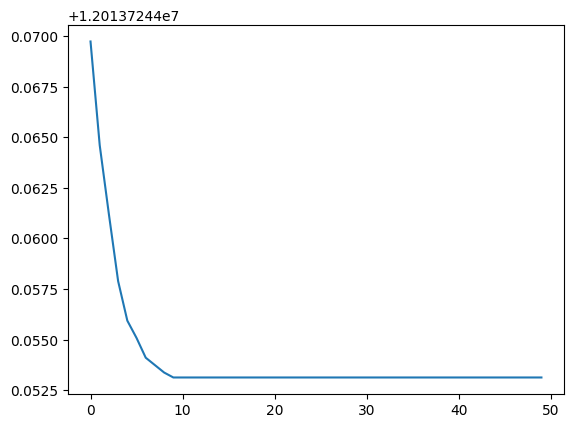

In [25]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [26]:
y_pred[0].detach().numpy()

array([[ 1.        ,  0.999993  ,  1.        ,  1.        ,  0.9999871 ,
         1.        ,  0.9999998 ,  1.        , -1.        ,  1.        ,
         1.        ,  1.        ,  1.        , -1.        ,  1.        ,
         0.99999994,  0.99999934,  1.        ,  1.        ,  1.        ,
         1.        ,  0.99999964,  1.        ,  1.        ,  0.9999956 ,
         1.        ,  1.        ,  1.        ,  0.9999991 ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  0.9999999 , -1.        ,
         0.99999994,  1.        ,  1.        ,  0.99999833,  1.        ,
         1.        ,  0.99999994,  1.        ,  0.9999994 ,  1.        ,
         1.        ,  1.        ,  0.99999994,  1.        ]],
      dtype=float32)

In [ ]:
plt.plot(y_pred[:,-1])
# plt.plot(Y_train)
plt.show()

TypeError: list indices must be integers or slices, not tuple